In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils import find_pauli_indices
from algo.utils import process_hamiltonian_Zs
from algo.utils import optimal_interp_points, interp_matrix
from algo.utils import hamiltonian_to_matrix

# This hamiltionian has two ground states
the ground energy is -5 with muliplicity 2

In [2]:
ham_str = "-3.0 + 0.5 * Z0 + 0.25 * Z1 + 0.25 * Z2 + 0.5 * Z3 + 0.75 * Z0*Z2 - 0.25 * Z1*Z2 + 0.25 * Z0*Z1 + 0.25 * Z0*Z3 + 0.75 * Z1*Z3 + 0.25 * Z2*Z3 - 0.25 * Z0*Z1*Z2 - 0.25 * Z1*Z2*Z3"
num_q = 4  # Number of qubits
max_stars = 3  # Maximum number of stars to categorize terms (e.g., 0-star, 1-star, 2-star, 3-star)

# Call the function to process the Hamiltonian string
all_lists, all_coeffs = process_hamiltonian_Zs(ham_str, num_q, max_stars)

# Output the results for each star category
for i, (term_positions, term_coeffs) in enumerate(zip(all_lists, all_coeffs)):
    print(f"Terms with {i} star(s):")
    print("Coefficients:", term_coeffs)
    print("Positions:", term_positions)

print('')

List_0, List_1, List_2, List_3 = all_lists
List = List_0 + List_1 + List_2 + List_3

coeff_0, coeff_1, coeff_2, coeff_3 = all_coeffs
coeff = coeff_0 + coeff_1 + coeff_2 + coeff_3

H = SparsePauliOp(List, coeff)
Hmat = Operator(H)
Hmat = Hmat.data

# CHECK IT IS THE SAME AS MATRIX FROM JAX PROBLEM
H2 = hamiltonian_to_matrix(ham_str)
print('difference between two matrices', np.linalg.norm(H2-Hmat.data))


Terms with 0 star(s):
Coefficients: [-3.0]
Positions: ['IIII']
Terms with 1 star(s):
Coefficients: [0.5, 0.25, 0.25, 0.5]
Positions: ['ZIII', 'IZII', 'IIZI', 'IIIZ']
Terms with 2 star(s):
Coefficients: [0.75, -0.25, 0.25, 0.25, 0.75, 0.25]
Positions: ['ZIZI', 'IZZI', 'ZZII', 'ZIIZ', 'IZIZ', 'IIZZ']
Terms with 3 star(s):
Coefficients: [-0.25, -0.25]
Positions: ['ZZZI', 'IZZZ']

difference between two matrices 0.0


In [3]:

# Compute eigenvalues and eigenvectors
e, v = eigh(Hmat)

# Identify the ground state (minimum eigenvalue)
ground_e = np.min(e)
min_index = np.argmin(e)
v_min = v[:, min_index]  # Ground state eigenvector

# Check degeneracy of the ground state
degeneracy = np.sum(np.isclose(e, ground_e))

# Print warning if ground state is not unique
if degeneracy > 1:
    print(f"Warning: Ground state is not unique. Degeneracy = {degeneracy}. Fidelity is not good metric.")
else:
    print("Ground state is unique.")
    
# Optional: Output for debugging
print(f"Ground state energy: {ground_e}")
print(f"Eigenvalues: {e}")


Ground state energy: -5.0
Eigenvalues: [-5. -5. -4. -4. -4. -4. -4. -4. -3. -3. -2. -2. -2. -1. -1.  0.]


In [4]:
# Check the ground state
for x in np.linalg.eigh(Hmat)[1][:, :2].T:
    print(np.nonzero(x))
print(int('0110', 2), int('1001', 2))
E_gs = np.linalg.eigh(Hmat)[0][0]
print(E_gs)

(array([6], dtype=int64),)
(array([9], dtype=int64),)
6 9
-5.0


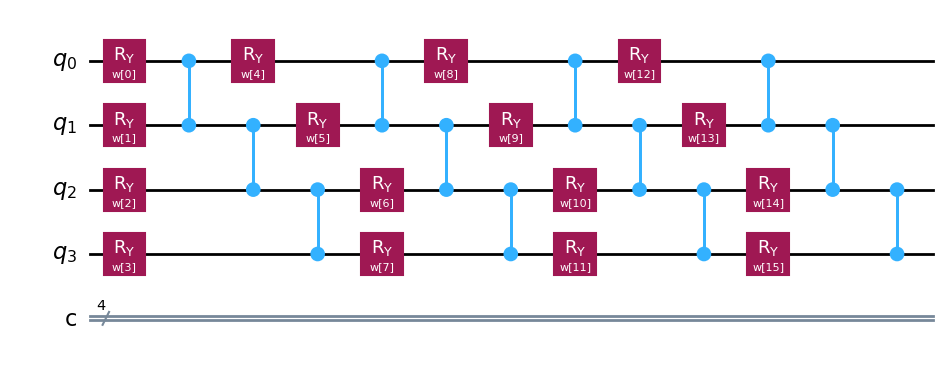

In [5]:
"""circuit construction"""
layer = 4  # Define the number of layer in the quantum circuit

# This needs to be determined based on the circuit
num_p = num_q * layer  # Calculate the number of parameters 

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

# Hardware-Efficient Ansatz
def circuit_HEA(weights):
    # ``QuantumCircuit(4, 3) 
    # A QuantumCircuit with 4 qubits and 3 classical bits
    circ = QuantumCircuit(num_q, num_q)  

    # WARNING: if initial state is not |0⟩^⊗n, then the convergence is not good.

    # # initial state is not |0⟩^⊗n
    # for i in range(layer):
    #     for j in range(num_q): 
    #         circ.ry(np.pi/4, j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
    #     for j in range(num_q-1):  
    #         circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits


    for i in range(layer):  # Iterate over each layer
        for j in range(num_q): 
            circ.ry(weights[num_q*i+j], j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
        for j in range(num_q-1):  
            circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits
    
    return circ  # Return the constructed quantum circuit

qc = circuit_HEA(weights)
# print(qc)
qc.draw("mpl")


In [6]:
simulator = AerSimulator()

Z_indices = []
ZZ_indices = []
ZZZ_indices = []

for pauli_str in List_1:
    # print(pauli_str)
    _, _, Z_index = find_pauli_indices(pauli_str)
    Z_indices.append(Z_index)

for pauli_str in List_2:
    # print(pauli_str)
    _, _, ZZ_index = find_pauli_indices(pauli_str)
    ZZ_indices.append(ZZ_index)

for pauli_str in List_3:
    # print(pauli_str)
    _, _, ZZZ_index = find_pauli_indices(pauli_str)
    ZZZ_indices.append(ZZZ_index)

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0 
    estimate_2 = 0
    estimate_3 = 0

    qc = circuit_HEA(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)

    for i in range(SHOTS):
        c_i = c[i]

        # List_1 = ['ZIII'] Terms with 1 star
        for j, index in enumerate(Z_indices): 
            if c_i[num_q-1-index[0]] == '0':
                estimate_1 += 1*coeff_1[j]
            else:
                estimate_1 += -1*coeff_1[j]
        
        # List_2 = ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ'] Terms with 2 stars
        for j, index in enumerate(ZZ_indices): 
            if c_i[num_q-1-index[0]] == c_i[num_q-1-index[1]]:
                estimate_2 += 1*coeff_2[j]
            else:
                estimate_2 += -1*coeff_2[j]

        # List_3 = ['ZZZI', 'ZZIZ', 'IZZZ', 'IIZI', 'IZIZ', 'ZIZZ'] Terms with 3 stars
        for j, index in enumerate(ZZZ_indices): 
            num = [c_i[num_q-1-index[0]],c_i[num_q-1-index[1]],c_i[num_q-1-index[2]]].count('1')
            if num % 2 == 0:
                estimate_3 += 1*coeff_3[j]
            else:
                estimate_3 += -1*coeff_3[j]

    estimate = estimate_1 + estimate_2 + estimate_3
    estimate = estimate/SHOTS + coeff_0[0] # coeff_0[0] for 'IIII'

    return estimate

def expectation_loss(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def fidelity(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2


def std(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))



In [7]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(std(weights))
print(expectation_loss(weights)/std(weights))
print(E_gs)

# Check if the observed values from the simulator follow a normal distribution
# Essentially, this is to check whether the estimate_loss function is correct
# It takes a long time
shots = 1000
if False:
    true_value = expectation_loss(weights)

    # 收集多次估计结果
    num_trials = 5000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=15, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


-2.8201922841121454
1.447038009805737
-1.9489413996048057
-5.0


In [8]:
from algo.utils import interp_matrix

weights_dict = {}

omegas = [1]
interp_nodes = np.linspace(0,2*np.pi,2*len(omegas)+1,endpoint=False)
# interp_nodes = np.random.uniform(0, 2*np.pi, size=2*len(omegas)+1)
inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))

for i in range(num_p):
    weights_dict[f'weights_{i}'] = {
        'omegas': omegas,
        'scale_factor': 1.0,
        'interp_nodes': interp_nodes,
        'inverse_interp_matrix': inverse_interp_matrix,
    }

print(weights_dict['weights_0'])
print(f'true ground state energy:',ground_e)

{'omegas': [1], 'scale_factor': 1.0, 'interp_nodes': array([0.       , 2.0943951, 4.1887902]), 'inverse_interp_matrix': array([[ 4.71404521e-01,  4.71404521e-01,  4.71404521e-01],
       [ 6.66666667e-01, -3.33333333e-01, -3.33333333e-01],
       [-1.92296269e-16,  5.77350269e-01, -5.77350269e-01]])}
true ground state energy: -5.0


In [9]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from algo.utils import check_is_trigometric  # Assuming check_is_trigometric is defined in utils module

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p//2):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)




 index to check =  0
omegas =  [1]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-3.79979986 -0.02361523  0.15805608]

 index to check =  1
omegas =  [1]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-3.4862839   0.31504784  0.20752487]

 index to check =  2
omegas =  [1]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-4.26609436 -0.20223441  0.95003219]

 index to check =  3
omegas =  [1]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-4.62800504 -0.61835729 -0.44285666]

 index to check =  4
omegas =  [1]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-4.73374065  0.46236778  0.21066921]

 index to check =  5
omegas =  [1]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-4.63712663  0.27988075 -0.12179037]

 index to check =  6
omegas =  [1]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-4.56060197  0.0433377   0.4191763 ]

 index to check =  7
omegas =  [1

In [12]:
# initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot = 1000
print(f"Ground state energy: {ground_e}")

Ground state energy: -5.0


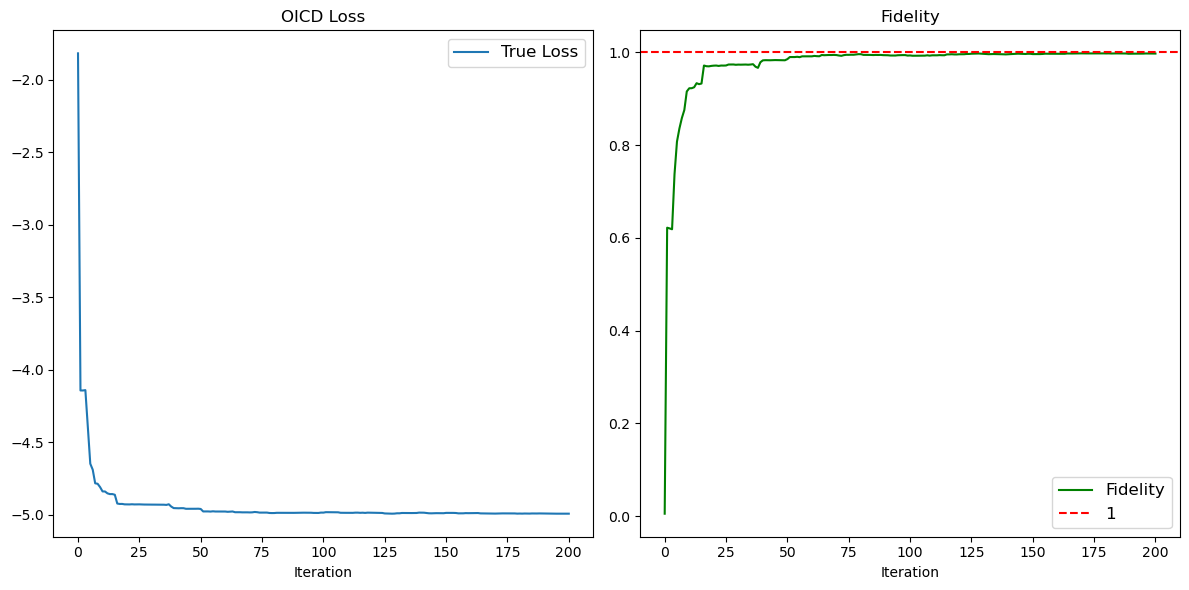

[OICD] Iter: 199, 11(16), Best loss: -4.9939, Cur. loss: -4.9937, Best Fid.: 0.9977, Cur. Fid.: 0.9972: 100%|██████████| 200/200 [01:00<00:00,  3.29it/s]


In [13]:
# OICD Optimization
from algo.oicd import oicd

num_iter = 200
# Run OICD
final_weights_oicd, best_expected_record_value_oicd, fidelity_record_value_oicd, func_oicd, _, _ = oicd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    use_pratical_interp_flag=True,
    use_local_solvers_flag=False,
    use_global_solvers_flag = False,
    use_eigen_method_flag = False,
    # subproblem_method='BFGS',
    # subproblem_iter=None,
    use_exact_update_frequencey_1_flag = True,
    exact_mode=False, # for testing purpose, no noisy loss
    plot_flag=True,
    plot_argmin_flag = False,
)

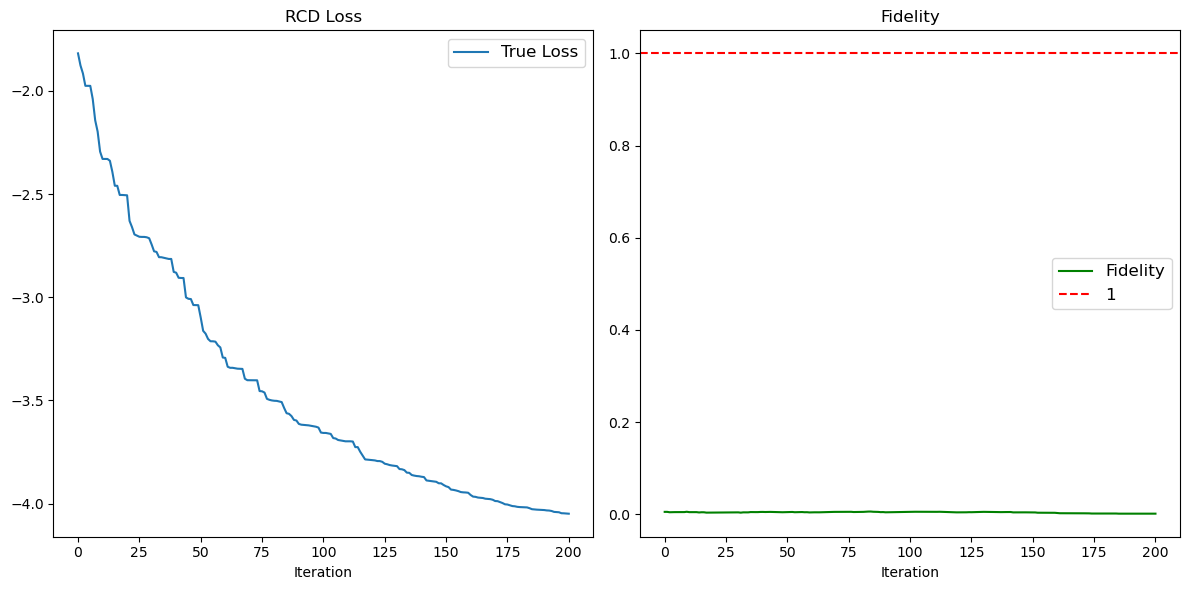

[RCD] Iter: 199, 1(16), Best loss: -4.0488, Cur. loss: -4.0488, Best Fid.: 0.0060, Cur. Fid.: 0.0014: 100%|██████████| 200/200 [01:00<00:00,  3.29it/s]


In [14]:
# RCD Optimization
from algo.rcd import rcd

num_iter = 200
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, fidelity_record_value_rcd, func_rcd, _, _ = rcd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    learning_rate=0.1,
    decay_step=10,
    decay_rate=-1,
    decay_threshold=1e-4,
    exact_mode=False,
    plot_flag=True,
)


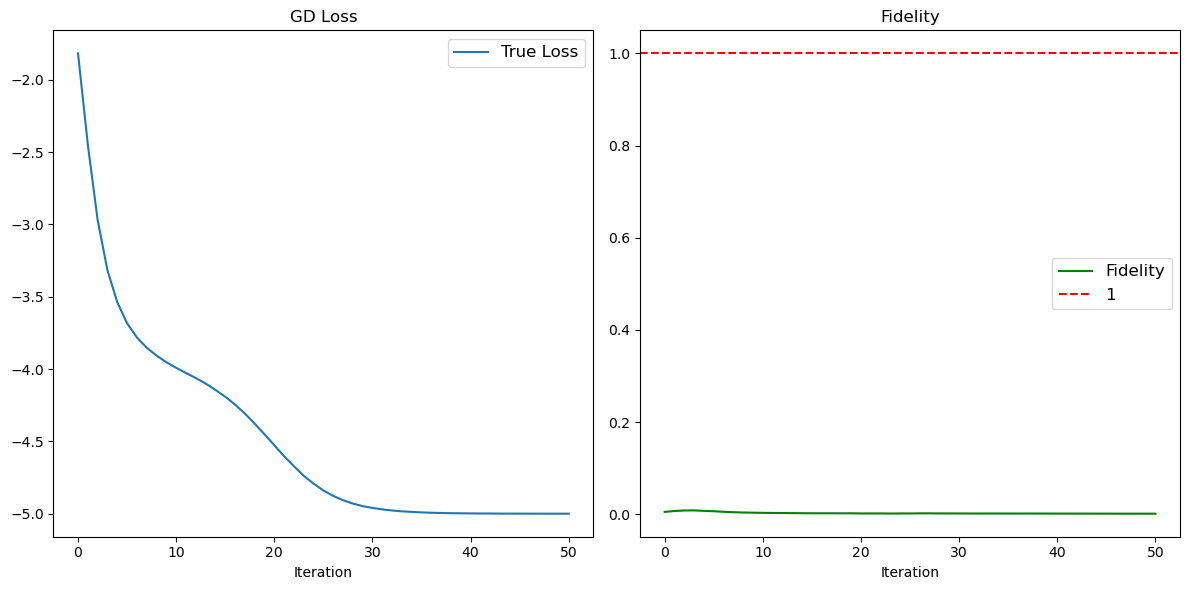

[GD] Iter: 49, Best loss: -4.9996, Cur. loss: -4.9996, Best Fid.: 0.0086, Cur. Fid.: 0.0014: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


In [15]:
# Gradient Descent Optimization
from algo.gd import gd

num_iter = 50
# Run GD
final_weights_gd, best_expected_record_value_gd, fidelity_record_value_gd, func_gd, _, _  = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.1,
    exact_mode=False,
    plot_flag=True,
)


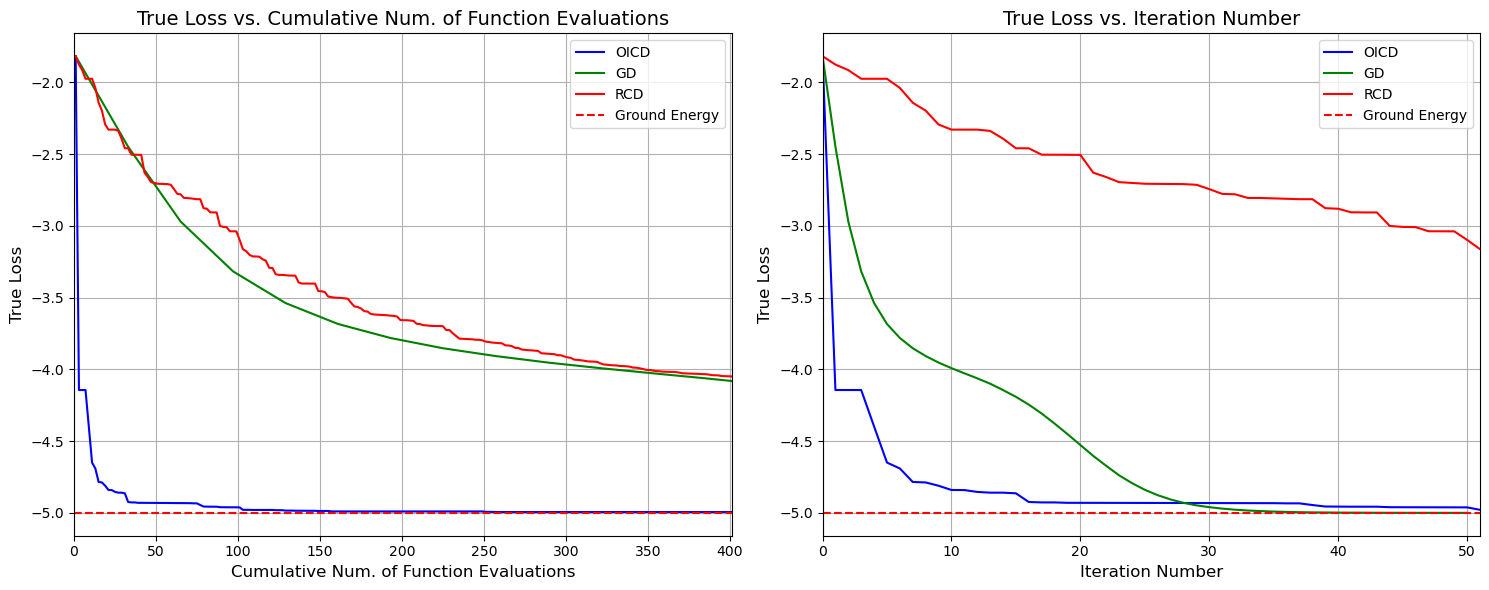

In [16]:
# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is the function value
axs[0].plot(func_oicd, best_expected_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_expected_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_expected_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*1
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is the function value
axs[1].plot(best_expected_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_expected_record_value_gd, label='GD', color='green')
axs[1].plot(best_expected_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Adjust the layout automatically to avoid overlapping labels between subplots
plt.tight_layout()

# Show the plot
plt.show()
